In [2]:
import tensorflow as tf
# %tensorflow_version 2.x
print('lol')
import numpy as np # Для работы с данными 
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами


from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN 
%matplotlib inline 
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import shuffle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import pymorphy2
import re
import nltk
nltk.download('stopwords')

# 1 - анализируем с нейтральными, 0 - анализируем без нейтральных отзывов
WITH_NEU = 1



lol


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/viktoria.nam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Путь к папке с текстовыми файлами
path = '/Users/viktoria.nam/Downloads/kp_8000'

# класс для морфологического анализа
morph = pymorphy2.MorphAnalyzer()

# Список возможных меток классов
labels = ['neu', 'neg', 'pos']

# Определяем максимальное количество слов в каждом документе
max_words = 25000

#стоп слова - не несущие смысловой нагрузки и эмоциональной окраски в текте
stop_words = stopwords.words('russian')
# Создаем пустые списки для текстов, меток и слов
texts = []
labels = []
words = []

# Цикл для перебора отзывов
for label in os.listdir(path)[1:]:
    print(label)
    if not (WITH_NEU == 0 and label == 'neu'):
        label_path = os.path.join(path, label)
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                text = text.lower()
                text = text.replace("\n", " ")
                splitted = text.split()
                splitted = [w for w in splitted if w not in stop_words]
                sp = []
                for w in splitted:
                    # очищаем слова от не букв
                    w = re.sub(r'[.,"\'-?:!;]', '', w)
                    # приводим слова к нормальным формам
                    w = morph.parse(w)[0].normal_form
                    sp.append(w)
                text = ' '.join(sp)
                texts.append(text)
                labels.append(label)
                words += text.split()
                f.close()

print(words[:200])

# Создаем словарь для подсчета частоты использования слов
word_count = {}
for word in words:
    if word not in word_count:
        word_count[word] = 1
    else:
        word_count[word] += 1

neu
neg
pos
['фильм', 'герой', 'необычный', 'способность', 'пользоваться', 'спрос', 'определённый', 'аудитория', 'зритель', 'коготь', 'кино', 'супермэн', 'бэтмэн', 'человекпаук', 'хэнкок', 'тд', 'мужчиныгерой', 'неудивительный', 'комуть', 'прийти', 'голова', 'наделить', 'уникальный', 'сила', 'женщина', 'мой', 'память', 'женщинакошко', 'соблазнительный', 'латексный', 'костюм', 'ряд', 'суперженщина', 'пополнить', 'ggirl', 'лицо', 'ум', 'турман', 'понять', 'это', 'некий', 'пародия', 'фильм', 'супергерой', 'акцент', 'стоить', 'доблестный', 'подвиг', 'ggirl', 'отношение', 'обычный', 'парень', 'мэтт', 'бедняга', 'думать', 'сначала', 'круто', 'повезти', 'смочь', 'закадрить', 'просто', 'девушка', 'супердевушка', 'оказаться', 'слишком', 'ревнивый', 'начаться', 'веселие', 'мэтт', 'тактично', 'пытаться', 'бросить', 'добрый', 'спасительница', 'мир', 'показать', 'он', 'насколько', 'коварный', 'отвергнуть', 'женщина', 'честной', 'пройти', 'мимо', 'фильм', 'дом', 'валяться', 'диск', 'они', 'сегодня',

In [4]:
# заменяем текстовые лейблы на классы
label_dict = {label: i for i, label in enumerate(set(labels))} 
labels = [label_dict[label] for label in labels]

In [5]:
print(texts[0])

# перемешиваем данные, чтобы в тестовой выборке было примерно равное количество отзывов разных классов
texts, labels = shuffle(texts, labels)


фильм герой необычный способность пользоваться спрос определённый аудитория зритель коготь кино супермэн бэтмэн человекпаук хэнкок тд мужчиныгерой неудивительный комуть прийти голова наделить уникальный сила женщина мой память женщинакошко соблазнительный латексный костюм ряд суперженщина пополнить ggirl лицо ум турман понять это некий пародия фильм супергерой акцент стоить доблестный подвиг ggirl отношение обычный парень мэтт бедняга думать сначала круто повезти смочь закадрить просто девушка супердевушка оказаться слишком ревнивый начаться веселие мэтт тактично пытаться бросить добрый спасительница мир показать он насколько коварный отвергнуть женщина честной пройти мимо фильм дом валяться диск они сегодня увидеть сниматься люк уилсон анна фэрис поэтому вставить свой dvdплейер сказать комедия прям смешной слеза пара хихикнуть можно настолько плохой ухо свернуться трубочка пошлый глупый шуточка несколько момент ниже пояс сравнивать другой комедия закрыть это глаз понравиться подвиг gg

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
#векторизуем тексты с помощью bow
texts_bow = vect.fit_transform(texts) 

In [7]:
#разделяем данные на обучающую и тестовую выборки
data_train_bow, data_test_bow, labels_train, labels_test = train_test_split(texts_bow, labels, test_size=0.3)

In [8]:
# преобразуем отзывы в массивы
data_train_bow = data_train_bow.toarray()
data_test_bow = data_test_bow.toarray()
print(data_train_bow.shape)
print(data_test_bow.shape)

(5457, 75981)
(2340, 75981)


In [9]:
if WITH_NEU == 1: 
    # если рассматриваем нейтральные, то 3 класса в векторизации лейблов
    test_labels_m = tf.keras.utils.to_categorical(labels_test, num_classes=3, dtype='float32')
    train_labels_m = tf.keras.utils.to_categorical(labels_train, num_classes=3, dtype='float32')
else:
    # если не рассматриваем - 2
    test_labels_m = tf.keras.utils.to_categorical(labels_test, num_classes=2, dtype='float32')
    train_labels_m = tf.keras.utils.to_categorical(labels_train, num_classes=2, dtype='float32')

started
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               15196400  
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 3)                 603       
                                                                 
Total params: 15,197,803
Trainable params: 15,197,403
Non-trainable params: 400
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
 Layer (t

2023-05-15 00:44:10.311344: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


43/43 [==============================] - 8s 168ms/step - loss: 1.0853 - accuracy: 0.5430 - val_loss: 0.9214 - val_accuracy: 0.5778
Epoch 2/15
43/43 [==============================] - 10s 234ms/step - loss: 0.2544 - accuracy: 0.9467 - val_loss: 0.8744 - val_accuracy: 0.5829
Epoch 3/15
43/43 [==============================] - 9s 215ms/step - loss: 0.0869 - accuracy: 0.9912 - val_loss: 0.8651 - val_accuracy: 0.5808
Epoch 4/15
43/43 [==============================] - 14s 337ms/step - loss: 0.0331 - accuracy: 0.9984 - val_loss: 0.8578 - val_accuracy: 0.5906
Epoch 5/15
43/43 [==============================] - 10s 236ms/step - loss: 0.0154 - accuracy: 0.9998 - val_loss: 0.8651 - val_accuracy: 0.5868
Epoch 6/15
43/43 [==============================] - 8s 190ms/step - loss: 0.0092 - accuracy: 0.9998 - val_loss: 0.8762 - val_accuracy: 0.5944
Epoch 7/15
43/43 [==============================] - 10s 240ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.8999 - val_accuracy: 0.5949
Epoch 8/15
43

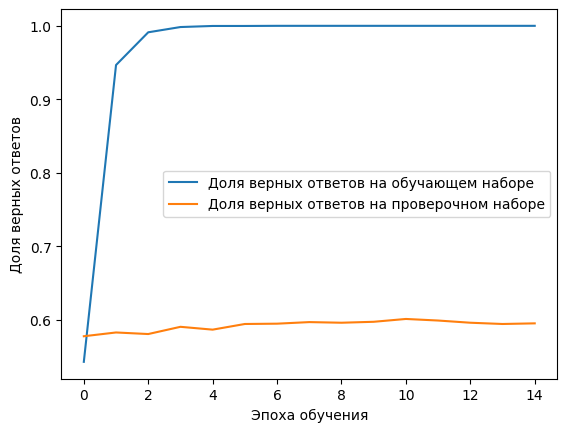

In [10]:
#Создаём сеть
print('started')
model = Sequential()
#Первый полносвязный слой
model.add(Dense(200, input_dim = data_train_bow.shape[1], activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())
#Выходной полносвязный слой
if WITH_NEU == 1:
    # если рассматриваем нейтральные, то 3 класса в векторизации лейблов
    model.add(Dense(3, activation = 'softmax'))
else:
    #если не рассматриваем - 2
    model.add(Dense(2, activation = 'softmax'))
print(model.summary())    
# Скомпилируем модель
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#Информация о модели
model.summary()

#Обучаем сеть 
history = model.fit(data_train_bow, train_labels_m, epochs=15, batch_size=128, validation_data=(data_test_bow, test_labels_m))

plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


In [3]:
import random
import numpy as np
from sklearn.cluster import KMeans

class TTMDP:
    # ... (ваш код)

def update_values_with_unsupervised(values, state, reward, next_state, alpha, gamma, cluster_labels):
    current_value = values.get((state, cluster_labels), 0)
    next_value = values.get((next_state, cluster_labels), 0)
    updated_value = current_value + alpha * (reward + gamma * next_value - current_value)
    values[(state, cluster_labels)] = updated_value

def unsupervised_learning(X):
    kmeans = KMeans(n_clusters=2, random_state=0)
    return kmeans.fit_predict(X)

def monte_carlo_with_td_learning_and_unsupervised(agent, num):
    values = {}
    flat_states = [tuple(row) for row in agent.states]
    X_unsupervised = np.array(flat_states).reshape(-1, 1)
    cluster_labels = unsupervised_learning(X_unsupervised)

    for _ in range(num):
        agent.reset()
        current_state = [row.copy() for row in agent.states]
        rewards = {0: 0, 1: 0, -1: 0}
        history = []

        while True:
            move, result = agent.move()
            history.append((tuple(row), result))

            if result is not None:
                break

            current_state[move[0]][move[1]] = 1

        rewards[result] = 1

        for i in range(len(history) - 1):
            state, _ = history[i]
            next_state, _ = history[i + 1]
            update_values_with_unsupervised(values, state, rewards[result], next_state, agent.alpha, agent.gamma, cluster_labels)

    return values

if __name__ == '__main__':
    process = TTMDP()
    num_simulations = 1000000

    learned_values = monte_carlo_with_td_learning_and_unsupervised(process, num_simulations)


IndentationError: expected an indented block (2953508221.py, line 8)